# Analyze boreal biomass by polygonal zone
* updated to try COGReader and its zonal_statistics
* some test output from first clipping attempts here: /projects/shared-buckets/lduncanson/test_output/analyze_agb

In [1]:
!pip install rasterstats

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install geopandas==0.10.0

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
#!pip install -U rio-cogeo>=3.0.0
!pip install -U rio-tiler>=3.0.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rio-tiler 2.1.4 requires morecantile<2.2,>=2.1, but you have morecantile 3.1.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [54]:
!pip install -U geojson-pydantic

  Preparing metadata (setup.py) ... done
  Created wheel for geojson-pydantic: filename=geojson_pydantic-0.3.3-py3-none-any.whl size=7105 sha256=592c9a85f4e37f92d99306e6568dd2c881a755f95156547d6ae67d72bb5e4868
  Stored in directory: /projects/.cache/pip/wheels/f9/d8/a0/305c71e7589f826311f37a9a386358b1aa4253efd58dc9a424
Successfully built geojson-pydantic
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [89]:
import os

import rio_tiler
import rasterstats
import rasterio
import rasterio.mask
from rasterio.plot import show
from shapely.geometry import mapping
from rasterstats import zonal_stats
import geopandas as gpd
import pandas as pd
import fiona
from fiona.crs import from_epsg
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [6, 6]

### Read in vector file of polygon zones and boreal tiles
* get the tiles intersecting zones of interest

In [3]:
# For geopandas sjoin, need v0.10.0+
print(gpd.__version__)
# Need rio_tiler >3.0
print(rio_tiler.__version__)

0.10.0
3.1.2


In [75]:
above_domain_gdf

,OBJECTID,Region,Shape_Leng,Shape_Area,geometry,area_sq_km
1,2,Core Region,2.918602e+07,4.089344e+12,"MULTIPOLYGON (((-516903.997 3046012.468, -5182...",4.089344e+06
0,1,Extended Region,4.184674e+07,2.259954e+12,"MULTIPOLYGON (((128142.996 2085540.487, 128130...",2.259954e+06


### Get boreal tiles intersecting the ABoVE domain

CPU times: user 11.2 s, sys: 172 ms, total: 11.4 s
Wall time: 13.5 s


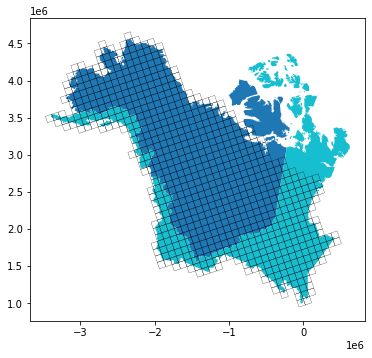

In [88]:
%%time
# Get the shp filename
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/arc/bioclimate_dd.shp'
# shp_fn = '/att/gpfsfs/briskfs01/ppl/pmontesa/userfs02/data/hydrobasins/hybas_lev03_clip_above.gpkg'
# shp_fn = '/projects/my-public-bucket/misc_files/hybas_lake_ar_lev08_v1c.shp'
# shp_fn = '/projects/my-public-bucket/misc_files/wwf_terr_ecos.shp'
#shp_fn = '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg'

# Reading in zones of interest
above_domain_fn = '/projects/shared-buckets/lduncanson/data/above/ABoVE_Study_Domain.shp'
above_domain_gdf = gpd.read_file(above_domain_fn)#.cx[-180:-150, 50:75]
above_domain_gdf['area_sq_km'] = above_domain_gdf.area / 1e6
above_domain_gdf.sort_values(by = 'area_sq_km', ascending=False, inplace=True)
above_crs = above_domain_gdf.crs

ax = above_domain_gdf.plot(column='Region')

# Reading in boreal tiles
boreal_tiles_fn = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_fn).to_crs(above_crs)

# Join or intersection
if False:
    # we want the boreal tiles that intersect the above domain...
    boreal_tiles_above = boreal_tiles.sjoin(above_domain_gdf, how='left', predicate='overlaps')
else:
    # What i actually want is a selection based on an intersection
    #boreal_tiles_above = boreal_tiles_above[boreal_tiles_above.tile_num.isin(boreal_tiles.geometry.intersects(above_domain_gdf.geometry).tile_num.to_list())]
    
    selector1 = boreal_tiles.intersects(above_domain_gdf.iloc[0].geometry)
    selector2 = boreal_tiles.intersects(above_domain_gdf.iloc[1].geometry)
    #selector = boreal_tiles.overlay(above_domain_gdf, how='intersection')
    #selector = boreal_tiles.overlay(above_domain_gdf, how='intersection')
    boreal_tiles_above = boreal_tiles[(selector1) | (selector2)]
    
boreal_tiles_above.geometry.boundary.plot(color=None, edgecolor='k',linewidth = .25, ax=ax)


## Build a VRT of the boreal biomass COGs
* use tindex master json to create a list for gdal

In [58]:
indir = '/projects/shared-buckets/lduncanson/DPS_tile_lists'
# a writable outdir
outdir = '/projects/my-public-bucket/analyze_agb'

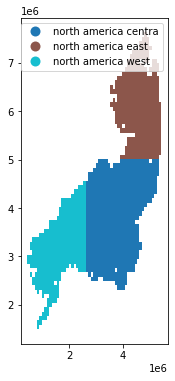

In [60]:
plt.rcParams['figure.figsize'] = [6, 6]
tile_json_fn = os.path.join(indir, "AGB_tindex_master.json")
tiles = gpd.read_file(tile_json_fn)

# North america subset
tiles_na = tiles[tiles['tile_group'].str.contains("america")]

tiles_na.plot(column='tile_group', legend=True)


#### Use tiles selection to write a vrt list

In [61]:
# Write a vrt list
vrt_list = os.path.join(outdir,"AGB_tindex_na.txt")

with open(vrt_list, 'w') as f:
    
    for text in tiles_na.s3.tolist():
        f.write(text.replace("s3:/","/vsis3") + '\n')

#### Build VRT of AGB COGs

In [112]:
vrt_fn = vrt_list.replace('.txt','.vrt')

#get the bbox as part of the gdalbuildvrt and define it, to save time calculating
tiles_na.total_bounds.tolist()
!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn

0...10...20...30...40...50...60...70...80...90...100 - done.

real	3m32.895s
user	0m3.827s
sys	0m0.506s


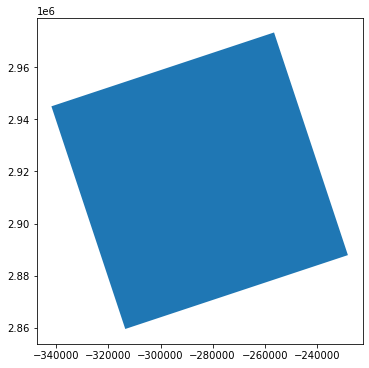

In [72]:
# Get a geojson feature for the zones
#geopandas.GeoSeries([shapely_polygon]).to_json()
#boreal_tiles.to_json()
test_zone = boreal_tiles_above[boreal_tiles_above.tile_num == 1983]#
#test_zone = boreal_tiles_above.iloc[0]
boreal_tiles_above.head()
test_zone.plot()

### Use rasterstats to access and analyze VRT

#### Read VRT of AGB COGs with rasterio

In [117]:
import rasterio.crs

with rasterio.open(vrt_fn, mode='r') as src:
    print(src.width, src.height)
    print(src.crs)
    print(src.indexes)
    to_crs = src.crs

165000 204000
PROJCS["unknown",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
(1,)


In [140]:
# Reproject the vector to the raster crs
in_gdf = boreal_tiles_above.to_crs(to_crs)
in_gdf.head()

,tile_num,tile_version,tile_group,map_version,geometry
1717,1718,version 1,north america east,None,"POLYGON ((3878522.000 5103304.000, 3968522.000..."
1718,1719,version 1,north america east,None,"POLYGON ((3968522.000 5103304.000, 4058522.000..."
1775,1776,version 1,north america centra,None,"POLYGON ((3068522.000 5013304.000, 3158522.000..."
1776,1777,version 1,north america centra,None,"POLYGON ((3158522.000 5013304.000, 3248522.000..."
1777,1778,version 1,north america centra,None,"POLYGON ((3248522.000 5013304.000, 3338522.000..."


### Run zonal_stats and attach to output geodataframe

In [ ]:
%%time
if False:
    # Use concat
    out_gdf = pd.concat([ in_gdf.reset_index(drop=True),
                pd.DataFrame(
                    rasterstats.zonal_stats(
                        vectors=in_gdf['geometry'], 
                        raster=vrt_fn, 
                        stats=['max','mean', 'median','std','min','sum','count']
                    )
                )],
               axis=1)
else:
    # Use join
    out_gdf = in_gdf.reset_index(drop=True).join(
        pd.DataFrame(
            rasterstats.zonal_stats(
                vectors=in_gdf['geometry'], 
                raster=vrt_fn, 
                stats=['max','mean', 'median','std','min','sum','count']
            )
        )
    )

ax = out_gdf.plot('median', cmap='viridis', legend=True, vmin=0, vmax=250, ax=ax)
print(ax)

In [139]:
out_gdf.head()

,tile_num,tile_version,tile_group,map_version,geometry,min,max,mean,count,sum,std,median
0,1718,version 1,north america east,None,"POLYGON ((3878522.000 5103304.000, 3968522.000...",278.860107,24906.691406,1736.711145,942087,1.636133e+09,1238.213948,1528.915161
1,1719,version 1,north america east,None,"POLYGON ((3968522.000 5103304.000, 4058522.000...",3.735876,456.653381,12.799246,7469838,9.560830e+07,9.430428,10.037302
2,1776,version 1,north america centra,None,"POLYGON ((3068522.000 5013304.000, 3158522.000...",2.005335,539.550354,14.591599,7397942,1.079478e+08,11.484933,11.361522
3,1777,version 1,north america centra,None,"POLYGON ((3158522.000 5013304.000, 3248522.000...",1.573152,413.717316,6.430181,7890035,5.073436e+07,5.302911,5.221301
4,1778,version 1,north america centra,None,"POLYGON ((3248522.000 5013304.000, 3338522.000...",2.024702,235.060593,9.646900,5932156,5.722692e+07,6.598474,7.683988


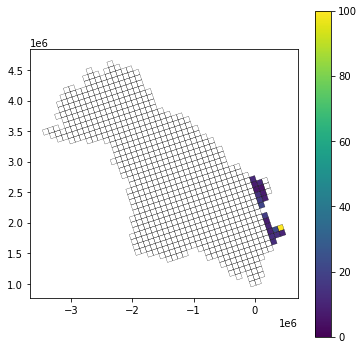

In [137]:
ax = boreal_tiles_above.geometry.boundary.plot(color=None, edgecolor='k',linewidth = .25)
out_gdf.to_crs(boreal_tiles_above.crs).plot('median', cmap='viridis', legend=True, vmin=0, vmax=100, ax=ax)

### Using COGReader to access and analze VRT
* select a test zone
* read the VRT: https://cogeotiff.github.io/rio-tiler/advanced/feature/
* get basic image stats: https://cogeotiff.github.io/rio-tiler/examples/Using-rio-tiler/
* get zonal stats: https://cogeotiff.github.io/rio-tiler/advanced/zonal_stats/

In [ ]:
from rio_tiler.io import COGReader
from rio_tiler.models import ImageData

Select a test zone

Read COG portion that intersects a feature

In [ ]:
with COGReader(vrt_fn) as cog:
    # Read data for a given geojson polygon
    z = cog.feature(test_zone.to_json())  # we limit the max_size to 1024

Test some basic image stats with COGReader

In [ ]:
with COGReader(vrt_fn) as cog:
    meta = cog.statistics(max_size=256)

    assert isinstance(meta, dict)
    print(list(meta))
    print(meta["1"].dict())

### Enable Zonal Stats with COGReader

In [55]:
import attr
from typing import Any, Union, Optional, List, Dict

from rio_tiler import io
from rio_tiler.utils import get_array_statistics
from rio_tiler.models import BandStatistics

from geojson_pydantic.features import Feature, FeatureCollection
from geojson_pydantic.geometries import Polygon

class COGReader(io.COGReader):
    """Custom COGReader with zonal_statistics method."""

    def zonal_statistics(
            self,
            geojson: Union[FeatureCollection, Feature],
            categorical: bool = False,
            categories: Optional[List[float]] = None,
            percentiles: List[int] = [2, 98],
            hist_options: Optional[Dict] = None,
            max_size: int = None,
            **kwargs: Any,
        ) -> FeatureCollection:
            """Return statistics from GeoJSON features.

            Args:
                geojson (Feature or FeatureCollection): a GeoJSON Feature or FeatureCollection.
                categorical (bool): treat input data as categorical data. Defaults to False.
                categories (list of numbers, optional): list of categories to return value for.
                percentiles (list of numbers, optional): list of percentile values to calculate. Defaults to `[2, 98]`.
                hist_options (dict, optional): Options to forward to numpy.histogram function.
                max_size (int, optional): Limit the size of the longest dimension of the dataset read, respecting bounds X/Y aspect ratio. Defaults to None.
                kwargs (optional): Options to forward to `self.preview`.

            Returns:
                FeatureCollection

            """
            kwargs = {**self._kwargs, **kwargs}

            hist_options = hist_options or {}

            # We transform the input Feature to a FeatureCollection
            if not isinstance(geojson, FeatureCollection):
                geojson = FeatureCollection(features=[geojson])

            for feature in geojson:
                # Get data overlapping with the feature (using COGReader.feature method)
                data = self.feature(
                    feature.dict(exclude_none=True),
                    max_size=max_size,
                    **kwargs,
                )

                # Get band statistics for the data
                stats = get_array_statistics(
                    data.as_masked(),
                    categorical=categorical,
                    categories=categories,
                    percentiles=percentiles,
                    **hist_options,
                )

                # Update input feature properties and add the statistics
                feature.properties = feature.properties or {}
                feature.properties.update(
                    {
                        "statistics": {
                            f"{data.band_names[ix]}": BandStatistics(
                                **stats[ix]
                            )
                            for ix in range(len(stats))
                        }
                    }
                )

            return geojson


In [53]:
import rio_tiler
print(rio_tiler.__version__)

3.1.2


# Test output from first clipping attempts

In [68]:
def get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP=False):
    '''
    From the input gdf get:
        geoms_list: the geoms (features) that you will use to clip
        zone_name_list: the names of the geoms (features)
    '''
    geoms_list = []
    zone_name_list = []

    for idx in input_gdf.index:
        #print(idx)
        geom =  input_gdf.loc[idx].geometry
        zonename =  input_gdf.loc[idx][zone_field_name]
        print(zone_field_name, zonename)
        if geom not in geoms_list:
            if SHOW_CLIP:
                gpd.GeoSeries(geom).plot()
            geoms_list.append(geom)
            zone_name_list.append(zonename)

    print(f'# of indiv features: {len(geoms_list)}')
    return [geoms_list, zone_name_list]

def do_clip(r_fn, input_gdf, zone_field_name, indir, outdir, vector_fn, SHOW_CLIP = True):
    
    geoms_list, zone_name_list = get_gdf_lists(input_gdf, zone_field_name, SHOW_CLIP = False)
    
    feature_pass_list = []
    feature_fail_list = []
    no_raster_intersection_list = []

    with rasterio.open(r_fn, "r") as r:

        for idx, zone_name in enumerate(zone_name_list):
            print(zone_name)
            geom = geoms_list[idx]
            
            feature_gdf = None
            try:
                feature_gdf = gpd.GeoDataFrame({'name':zone_name, 'geometry':geom}, crs=from_epsg(4326)) #index=[0], 
                feature_gdf.plot()
                # Reproject feature_gdf to raster crs
                feature_gdf = feature_gdf.to_crs(r.crs)
            except ValueError:
                print(f"Cant get geodataframe for feature {zone_name}")
                feature_fail_list.append(zone_name)
                
                continue

            zone_name = f'{zone_name:03}'
            out_r_fn = os.path.join(os.path.split(r_fn.replace(indir, outdir))[0] , os.path.split(r_fn)[1].replace(os.path.splitext(r_fn)[1], '_'+vector_fn+'_'+zone_name+'.tif'))

            try:

                out_image, out_transform = rasterio.mask.mask(dataset=r, shapes=feature_gdf.geometry, crop=True)

                # Copy the metadata
                out_meta = r.meta.copy()
                out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs":r.crs.to_proj4()}
                                 )
                with rasterio.open(out_r_fn, "w", **out_meta) as out_r:
                    out_r.write(out_image)

                    print("Zone", zone_name, "clip of",  os.path.split(r_fn)[1])
                    print("Writing clipped subset to", out_r_fn)
                    feature_pass_list.append(zone_name)

                    #show(out_r, cmap='viridis') # <-- this show() is not working here..need to read the raster in again?

                # HERE IS WHERE WE CAN DO rasterstat's zonal_stats.
                if SHOW_CLIP:
                    show((rasterio.open(out_r_fn)), cmap='viridis')# <-- this show() works

            except ValueError:
                print(zone_name, " has no intersection with", os.path.split(r_fn)[1])
                no_raster_intersection_list.append(zone_name)
    print(f'# features that produced clips: {len(feature_pass_list)}')
    print(f'# features that failed to produce geodataframes: {len(feature_fail_list)}')
    print(f'# features that didnt have intersection with raster: {len(no_raster_intersection_list)}')

HYBAS_ID 8080000010
HYBAS_ID 8089023840
HYBAS_ID 8080000061
HYBAS_ID 8080000062
HYBAS_ID 8089051211
# of indiv features: 5
8080000010
Cant get geodataframe for feature 8080000010
8089023840
Cant get geodataframe for feature 8089023840
8080000061


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000061 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000061.tif


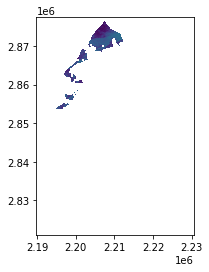

8080000062


/projects/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Zone 8080000062 clip of AGB_tindex.vrt
Writing clipped subset to /projects/my-public-bucket/test_output/analyze_agb/AGB_tindex_hybas_lev08_8080000062.tif


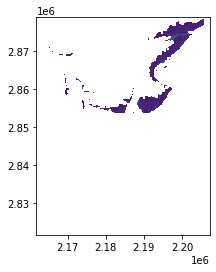

8089051211
Cant get geodataframe for feature 8089051211
# features that produced clips: 2
# features that failed to produce geodataframes: 3
# features that didnt have intersection with raster: 0


In [69]:
do_clip(r_fn, vector_gdf.head(), zone_field_name, indir, outdir, vector_file_name, SHOW_CLIP = True)